# Test SageMaker endpoint

In [1]:
import json
import re
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import boto3
import sagemaker

from aws_profiles import UserProfiles
profiles = UserProfiles()

## Pick the AWS profile you want to use

In [8]:
profile = "prod"
profile_id = profiles.get_profile_id(profile)

session = boto3.Session(profile_name=profile)
dev_s3_client = session.client("s3")
sm_client = session.client('sagemaker-runtime')

In [9]:
sm_session = sagemaker.Session(boto_session=session)
default_bucket = sm_session.default_bucket()

iam = session.client("iam")
role_arn = iam.get_role(RoleName=f"{profile_id}-sagemaker-exec")["Role"]["Arn"]

## 1. Run Inference on deployed endpoint

### 1.1 Load eval data from S3

In [4]:
s3_client = session.client("s3")
file_path = "data/val.csv"

s3_object = s3_client.get_object(Bucket=default_bucket, Key=file_path)
body = s3_object["Body"]
csv_string = body.read().decode("utf-8")
df = pd.read_csv(StringIO(csv_string), index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()


,description,medical_specialty,sample_name,transcription,keywords
0,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
1,"Degenerative disk disease of the right hip, l...",Consult - History and Phy.,Orthopedic Consult - 2,"SUBJECTIVE:, The patient comes back to see me...","consult - history and phy., scoliosis, lumbar,..."
2,DDDR permanent pacemaker. Tachybrady syndro...,Surgery,Pacemaker - DDDR,"PROCEDURE PERFORMED: ,DDDR permanent pacemake...",NaN
3,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
4,D&C and hysteroscopy. Abnormal uterine bleed...,Surgery,D&C & Hysteroscopy Followup,"PREOPERATIVE DIAGNOSES:,1. Abnormal uterine b...","surgery, pelvic examinatio, abnormal uterine b..."


### 1.2 Show examples

In [5]:
inputs = df.transcription.tolist()
targets = df.medical_specialty.tolist()

n_prints = 10
for t, i in zip(targets[:n_prints], inputs[:n_prints]):
    text_block = re.sub("(.{120})", "\\1\n", i, 0, re.DOTALL)
    print(f"'{t}': \n {text_block[:500]} ... \n")

' Cardiovascular / Pulmonary': 
 2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle
.,3.  Normal LV systolic function with left ventricular ejection fraction of 51%.,4.  Normal LV diastolic function.,5.  
No pericardial effusion.,6.  Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7.  
PA systolic pressure is 36 mmHg.,DOPPLER: , ,1.  Mild mitral and tricuspid regurgitation.,2.  Trace aortic and pulmonary
 regurgitation. ... 

' Consult - History and Phy.': 
 SUBJECTIVE:,  The patient comes back to see me today.  She is a pleasant 77-year-old Caucasian female who had seen Dr. X
YZ with right leg pain.  She has a history of prior laminectomy for spinal stenosis.  She has seen Dr. XYZ with low back
 pain and lumbar scoliosis post laminectomy syndrome, lumbar spinal stenosis, and clinical right L2 radiculopathy, which
 is symptomatic.  Dr. XYZ had performed two right L2-L3 transfora

### 1.3 Run prediction on endpoint

In [10]:
endpoint_name = f"{profile_id}-endpoint"
CONTENT_TYPE_JSON = "application/json"
payload = json.dumps({"instances": inputs})

response = sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=CONTENT_TYPE_JSON,
    Accept=CONTENT_TYPE_JSON,
    Body=payload,
)

prediction = json.loads(response["Body"].read())["prediction"]

results = pd.DataFrame()
results["pred"] = prediction
results["target"] = targets
results["correct"] = results.apply(lambda x: x.pred == x.target, axis=1)
results.head()

,pred,target,correct
0,Surgery,Cardiovascular / Pulmonary,False
1,Consult - History and Phy.,Consult - History and Phy.,True
2,Surgery,Surgery,True
3,Surgery,Bariatrics,False
4,Surgery,Surgery,True


### 1.4 Eval results

Accuracy: 31.812%


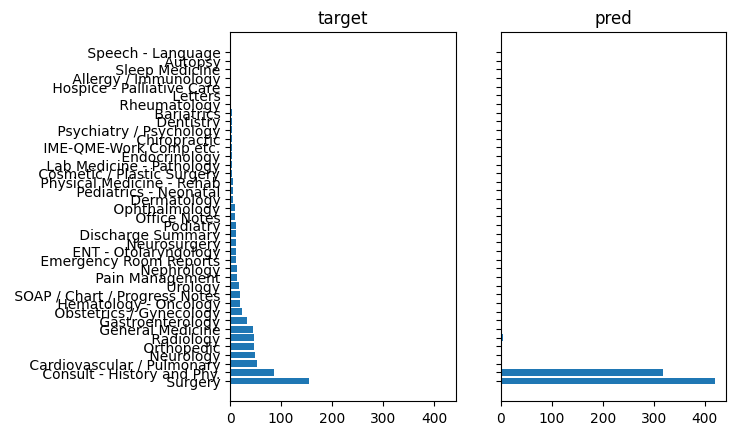

In [11]:
counts_tar = results['target'].value_counts()
counts_pred = results['pred'].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
ax1.barh(counts_tar.index, counts_tar.values)
ax1.set_title('target')
ax2.barh(counts_pred.index, counts_pred.values)
ax2.set_title('pred')

print(f"Accuracy: {results.correct.mean()*100:.3f}%")
plt.show()


#### Confusion matrix

In [ ]:
confusion_matrix = pd.crosstab(results['target'], results['pred'],)
i = confusion_matrix.index.union(confusion_matrix.columns)
confusion_matrix = confusion_matrix.reindex(index=i, columns=i, fill_value=0)
sn.heatmap(confusion_matrix.to_numpy(), annot=True)

## 2. Run batch inference (Transformer)
Use latest approved model from model registry

In [54]:
def get_latest_approved_model_package(model_package_group_name):
    """Retrieves the latest approved model package name from a given SageMaker model package group."""
    sm_client = session.client('sagemaker')
    model_package_arns = sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name)["ModelPackageSummaryList"]

    approved_model_package_arns = [
        d for d in model_package_arns if d['ModelApprovalStatus'] == "Approved"]

    if len(approved_model_package_arns) != 0:
        model_package_arn = approved_model_package_arns[0]["ModelPackageArn"]
        return model_package_arn

In [56]:
def get_endpoint_model_name():
    """Get the model name of the latest approved model package"""
    sm_client = session.client('sagemaker')
    target_package = get_latest_approved_model_package("training-pipelineModelGroup")
    
    # find model of corresponding endpoint
    for m in sm_client.list_models()["Models"]:
        package_name = sm_client.describe_model(ModelName=m["ModelName"])[
            "Containers"][0]["ModelPackageName"]
        if package_name == target_package:
            return m["ModelName"]

In [58]:
CONTENT_TYPE_CSV = 'text/csv'
CONTENT_TYPE_JSON = "application/json"

input_data_path = f"s3://{default_bucket}/data/val.csv"
output_data_path = f"s3://{default_bucket}/data/out"

model_name = get_endpoint_model_name()

response = sm_client.create_transform_job(
    TransformJobName='BatchTransform',
    ModelName=model_name,

    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': input_data_path
            }
        },
        'ContentType': CONTENT_TYPE_CSV,
    },
    TransformOutput={
        'S3OutputPath': output_data_path,
        'Accept': CONTENT_TYPE_CSV,
    },

    TransformResources={
        'InstanceType': "ml.g4dn.xlarge",
        'InstanceCount': 2,
    },
)

arn:aws:sagemaker:eu-west-3:157261447749:model-package/training-pipelinemodelgroup/2
